## Mobile Gaming A/B Testing Analysis

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import duckdb

from statsmodels.stats.proportion import proportions_ztest

**Cookie Cats** is a mobile puzzle game developed by Tactile Entertainment. It's a "connect three" style puzzle game where players need to connect tiles of the same color to clear the board and win the level.<br>

In [4]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/GaP5f0jVTWE?si=YNYwm3SSV6Z57LhD" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

Cookie Cats has **a monetization strategy- progression gates.** These gates, strategically placed in certain levels, gets the player to either wait or make an in-app purchase- in order to keep playing the game and move-up in the game levels.<br>
This mechanic not only drives revenue but also aims to enhance the player’s enjoyment by preventing burnout.

In the **current settings**, the first gate is located at level 30.<br>
<h4>A question rises- can we increase the retention if we put the gate in another location?</h4>

To test this theory- an **A/B test** was conducted- where the gate was **relocated to level 40** for a subset group of players, and the goal was to investigate the **player's retention impact** from this relocating.

The dataset of the A/B test on the Cookie Cats mobile game contains 5 columns: <br>
1. <code>userid</code>- A unique number identifies each player 
2. <code>version</code>- Whether the player is assigned to the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
3. <code>sum_gamerounds</code>- The number of game rounds played by the player during the first week after installation.
4. <code>retention_1</code>- Whether the player returned to play the game 1 day after installation.
5. <code>retention_7</code>- Whether the player returned to play the game 7 days after installation.

What is **retention** in terms of mobile gaming?<br>
Game retention is a metric that indicates how effectively your game engages players and gets them to return.<br>

It’s always measured over time, and represents the percentage of users who continue playing 1 day, 30 days, or even 180 days after install.
Player retention is crucial to understanding your game's overall health and estimating its long-term success:
- **High player retention rates** suggest that your game is consistently delivering a compelling and rewarding experience, encouraging players to invest their time - and possibly money. <br>
- **Low game retention rates** often indicate your gameplay and player experience needs adjustment - and quick.

In [5]:
df=pd.read_csv("cookie_cats.csv")
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


Checking for null values, data types of each column

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


Checking for duplicated rows

In [7]:
df[df.duplicated()].sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: object

Since I know that <code>gate_30</code> means that the user was assigned to the **control group**, and <code>gate_40</code> means that the user was assigned to the **test group**- I'll change the terms in the <code>version</code> column to **control** and **test** accordingly.

In [8]:
df['version']=df['version'].replace({'gate_30':'control', 'gate_40':'test'})
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,control,3,False,False
1,337,control,38,True,False
2,377,test,165,True,False
3,483,test,1,False,False
4,488,test,179,True,True


<Axes: title={'center': 'Player Count in Each Group'}, xlabel='version'>

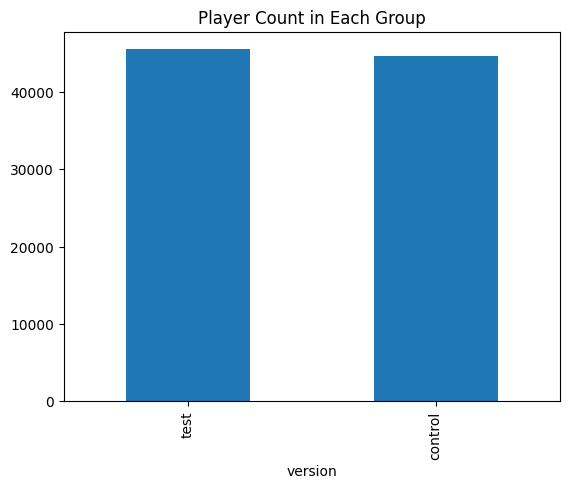

In [9]:
df['version'].value_counts().plot(kind='bar', title='Player Count in Each Group')

I want to see how many players played 0 gamerounds over the 7 days after they installed the game

Text(0.5, 1.0, 'Gamerounds in Installed App')

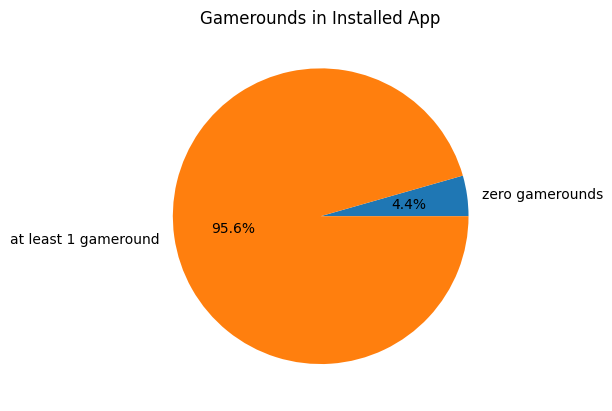

In [25]:
zero_games=df[df['sum_gamerounds']==0]
percentage=100*(len(zero_games)/len(df))

labels=['zero gamerounds', 'at least 1 gameround']
plt.pie([percentage, 100-percentage], labels=labels, autopct='%1.1f%%')
plt.title('Gamerounds in Installed App')

I see that 4.4% of the population, which are 3994 players has played 0 gamerounds between the time they install the game and a week afterwards.<br>
This could be because of number of reasons-
1. They became interested in other games.
2. They opened the app but closed it without playing because they didn't like the design or interface.
3. They downloaded the game but haven't started playing yet.

Now, because the definition of <code>retention_1</code> and <code>retention_7</code> is 'Whether the player returned to play the game 1/7 day after installation'- I refer 'play the game' as **played at least one gameround**- and expect to see 'False' in both <code>retention_1</code> and <code>retention_7</code> columns

In [28]:
zero_games.groupby('version')[['retention_1', 'retention_7']].value_counts()

version  retention_1  retention_7
control  False        False          1881
         True         False            40
         False        True             15
         True         True              1
test     False        False          2002
         True         False            42
         False        True              9
         True         True              4
Name: count, dtype: int64

As I can see- for both groups there are 111 (all other combination other than False and False) that have at least one 'True'- which based on the dataset definition cannot be.<br>
I'll refer it as a **Data Entry Error** and will remove it from the dataset.

In [34]:
df_to_drop=df[(df['sum_gamerounds']==0) & ~((df['retention_1']==False) & (df['retention_7']==False))]
df=df[~df.isin(df_to_drop.to_dict(orient='list')).all(axis=1)]
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,control,3,False,False
1,337,control,38,True,False
2,377,test,165,True,False
3,483,test,1,False,False
4,488,test,179,True,True
...,...,...,...,...,...
90184,9999441,test,97,True,False
90185,9999479,test,30,False,False
90186,9999710,control,28,True,False
90187,9999768,test,51,True,False


I want to get some descriptive analytics on the 2 groups

In [38]:
df.groupby('version').describe([0.10, 0.25, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]]

sum_gamerounds                                                    \
                 count       mean         std  min  10%  25%   50%   80%   
version                                                                    
control        44644.0  52.522063  256.870658  0.0  1.0  5.0  17.0  66.0   
test           45434.0  51.360875  103.341489  0.0  1.0  5.0  16.0  68.0   

                                        
           90%    95%     99%      max  
version                                 
control  135.0  222.0  493.00  49854.0  
test     134.0  220.0  492.67   2640.0

As I can see, there's no such difference between the groups, but I can see significant outliers in the control group that may skew the analysis- the max value is 49,854 which can explain the higher std.<br>
I'll see it more clearly in a boxplot

<Figure size 800x600 with 0 Axes>

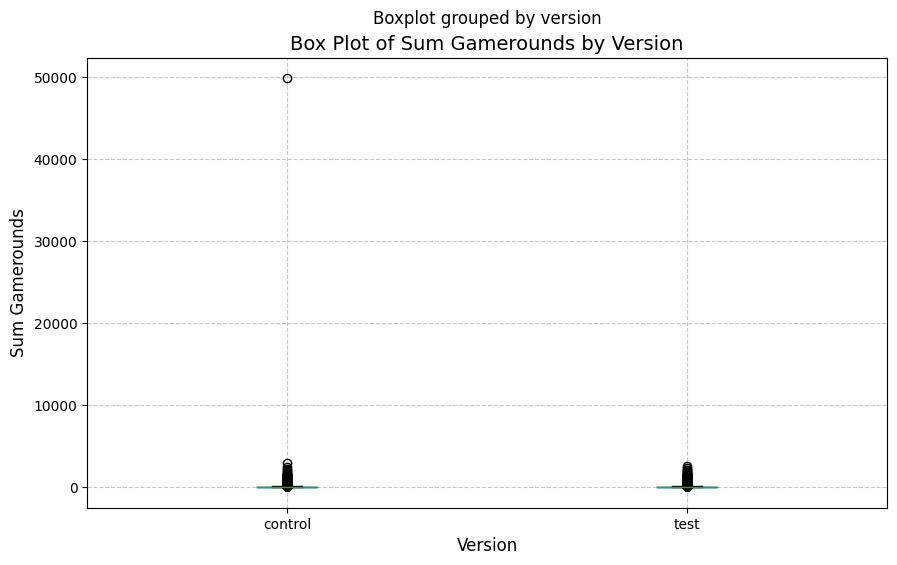

In [39]:
plt.figure(figsize=(8, 6))
df.boxplot(column='sum_gamerounds', by='version', figsize=(10, 6))

plt.title('Box Plot of Sum Gamerounds by Version', fontsize=14)  
plt.xlabel('Version', fontsize=12) 
plt.ylabel('Sum Gamerounds', fontsize=12) 

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

As I can see from the plot- the massive outlier is what's causing the shift in std- and can cause to misleading results.<br>
I'll remove it from the data and will re-check the statistics

In [40]:
df = df[df["sum_gamerounds"] < df["sum_gamerounds"].max()]

In [41]:
df.groupby('version').describe([0.10, 0.25, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]]

sum_gamerounds                                                    \
                 count       mean         std  min  10%  25%   50%   80%   
version                                                                    
control        44643.0  51.406514  102.105378  0.0  1.0  5.0  17.0  66.0   
test           45434.0  51.360875  103.341489  0.0  1.0  5.0  16.0  68.0   

                                       
           90%    95%     99%     max  
version                                
control  135.0  222.0  493.00  2961.0  
test     134.0  220.0  492.67  2640.0

<Figure size 800x600 with 0 Axes>

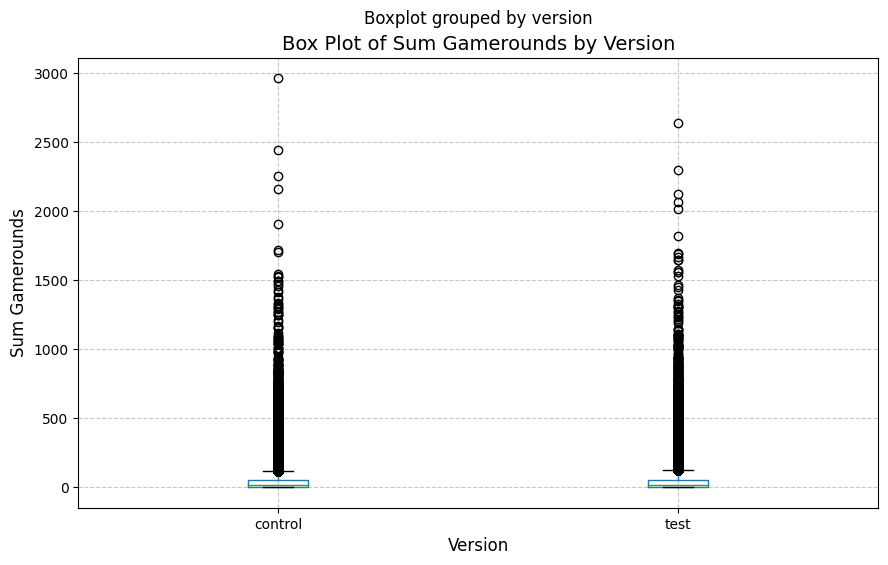

In [42]:
plt.figure(figsize=(8, 6))
df.boxplot(column='sum_gamerounds', by='version', figsize=(10, 6))

plt.title('Box Plot of Sum Gamerounds by Version', fontsize=14)  
plt.xlabel('Version', fontsize=12) 
plt.ylabel('Sum Gamerounds', fontsize=12) 

plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

After this cleaning process, I can get back to the main goal of this notebook- to see if the retention among the different groups changes? <br>

My main goal for this game is to get players 'addicted' to it. A common way in the game industry to see if players love the game is with **high 1-day retention rate**

In [59]:
print('The overall retention rate after 1 day of installing the app is {:.2f}%'.format(100*df['retention_1'].sum() / df['userid'].count()))


The overall retention rate after 1 day of installing the app is 44.48%


In [60]:
100*df.groupby('version')['retention_1'].sum() / df.groupby('version')['userid'].count()

version
control    44.784177
test       44.180570
dtype: float64

I can see a little decrease in 1-day retention in the test group- the group that moved their gate to level 40. <br>
Now, I'll see the results for 7-day retention rate

In [61]:
print('The overall retention rate after 7 days of installing the app is {:.2f}%'.format(100*df['retention_7'].sum() / df['userid'].count()))

The overall retention rate after 7 days of installing the app is 18.60%


In [62]:
100*df.groupby('version')['retention_7'].sum() / df.groupby('version')['userid'].count()

version
control    19.006339
test       18.193423
dtype: float64

Again, I see a difference between the 2 groups, with a slight decrease in the test group. <br>
I see that the retention is changing among the 2 groups- but I want to be sure in the difference, meaning, I want to make sure that the control group did better and not because of a random luck.

I'll use the **Bootstrapping method for A/B testing** in the <code>retention_1</code> and <code>retention_7</code> columns:
- the data is non-normal
- it estimates difference without assumptions
- bootstrapping helps provide a clear picture of whether the observed difference is meaningful, even if the differences are small

In [75]:
# Separate the data into the two groups
group_control = df[df['version'] == 'control']['retention_1'].astype(int)
group_test = df[df['version'] == 'test']['retention_1'].astype(int)

# Bootstrapping parameters
n_iterations = 10000
sample_size_control = len(group_control)
sample_size_test = len(group_test)

bootstrap_differences = []

# Perform bootstrapping
for _ in range(n_iterations):
    # Resample both groups
    sample_control = np.random.choice(group_control, size=sample_size_control, replace=True)
    sample_test = np.random.choice(group_test, size=sample_size_test, replace=True)
    
    # Compute retention rates for both groups
    retention_rate_control = np.mean(sample_control)
    retention_rate_test = np.mean(sample_test)
    
    # Compute the difference in retention rates
    bootstrap_differences.append(retention_rate_test - retention_rate_control)

# Calculate confidence intervals
lower_bound = np.percentile(bootstrap_differences, 2.5) #lower bound of a 95% CI
upper_bound = np.percentile(bootstrap_differences, 97.5) #upper bound of a 95% CI

# Mean difference
mean_difference = np.mean(bootstrap_differences)

# Display results
print('The average difference in 1-day retention rates between test and control across all bootstrap samples is {:.5f}'.format(mean_difference))
print('The 95% CI- the range of values where the true difference in retention rates is likely to fall is [{:.5f},{:.5f}]'.format(lower_bound,upper_bound))

The average difference in 1-day retention rates between test and control across all bootstrap samples is -0.00602
The 95% CI- the range of values where the true difference in retention rates is likely to fall is [-0.01237,0.00047]


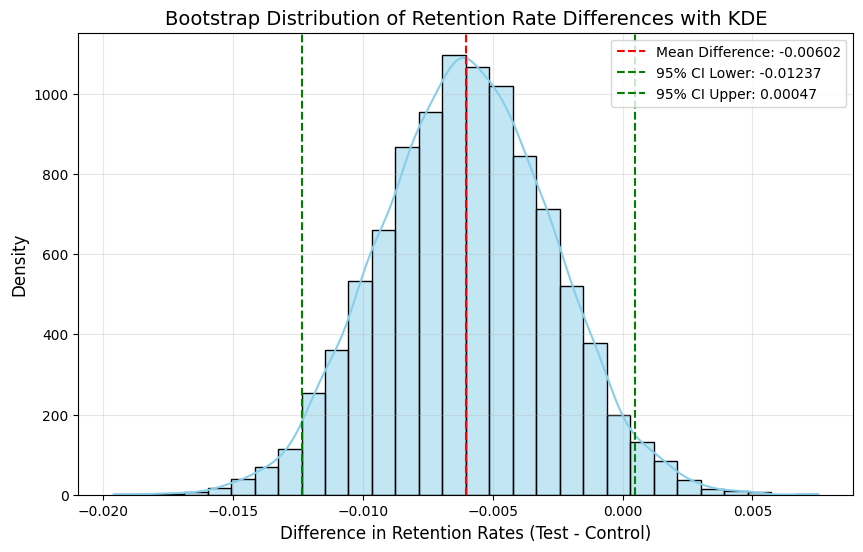

In [76]:
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_differences, bins=30, kde=True, color='skyblue', edgecolor='black')
plt.axvline(x=mean_difference, color='red', linestyle='--', label=f'Mean Difference: {mean_difference:.5f}')
plt.axvline(x=lower_bound, color='green', linestyle='--', label=f'95% CI Lower: {lower_bound:.5f}')
plt.axvline(x=upper_bound, color='green', linestyle='--', label=f'95% CI Upper: {upper_bound:.5f}')
plt.title('Bootstrap Distribution of Retention Rate Differences with KDE', fontsize=14)
plt.xlabel('Difference in Retention Rates (Test - Control)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()


Key observations-
- The mean difference is -0.00602- suggesting the the test group has a little lower 1-day retention rate than the control group.
- the Coinfidence Interval (CI) includes 0- suggesting that there is no significant difference between the test and control group, it could be because of random variation.

I'd do the same process for the 7-day retention

In [78]:
# Separate the data into the two groups
group_control = df[df['version'] == 'control']['retention_7'].astype(int)
group_test = df[df['version'] == 'test']['retention_7'].astype(int)

# Bootstrapping parameters
n_iterations = 10000
sample_size_control = len(group_control)
sample_size_test = len(group_test)

bootstrap_differences = []

# Perform bootstrapping
for _ in range(n_iterations):
    # Resample both groups
    sample_control = np.random.choice(group_control, size=sample_size_control, replace=True)
    sample_test = np.random.choice(group_test, size=sample_size_test, replace=True)
    
    # Compute retention rates for both groups
    retention_rate_control = np.mean(sample_control)
    retention_rate_test = np.mean(sample_test)
    
    # Compute the difference in retention rates
    bootstrap_differences.append(retention_rate_test - retention_rate_control)

# Calculate confidence intervals
lower_bound = np.percentile(bootstrap_differences, 2.5) #lower bound of a 95% CI
upper_bound = np.percentile(bootstrap_differences, 97.5) #upper bound of a 95% CI

# Mean difference
mean_difference = np.mean(bootstrap_differences)

# Display results
print('The average difference in 7-day retention rates between test and control across all bootstrap samples is {:.5f}'.format(mean_difference))
print('The 95% CI- the range of values where the true difference in retention rates is likely to fall is [{:.5f},{:.5f}]'.format(lower_bound,upper_bound))

The average difference in 7-day retention rates between test and control across all bootstrap samples is -0.00812
The 95% CI- the range of values where the true difference in retention rates is likely to fall is [-0.01323,-0.00313]


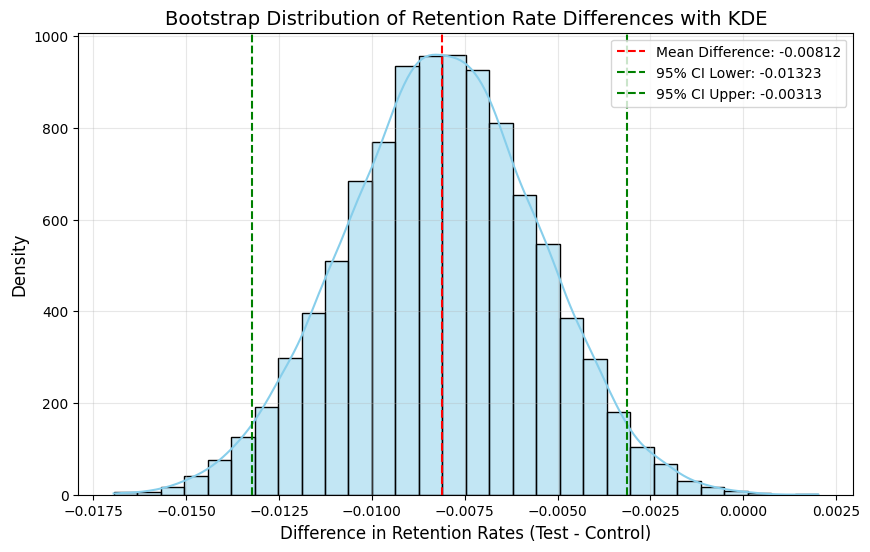

In [79]:
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_differences, bins=30, kde=True, color='skyblue', edgecolor='black')
plt.axvline(x=mean_difference, color='red', linestyle='--', label=f'Mean Difference: {mean_difference:.5f}')
plt.axvline(x=lower_bound, color='green', linestyle='--', label=f'95% CI Lower: {lower_bound:.5f}')
plt.axvline(x=upper_bound, color='green', linestyle='--', label=f'95% CI Upper: {upper_bound:.5f}')
plt.title('Bootstrap Distribution of Retention Rate Differences with KDE', fontsize=14)
plt.xlabel('Difference in Retention Rates (Test - Control)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.show()


Key observations-
- the mean difference is -0.00812- meaning on average- the 7-day retention rate is 0.81% lower for the test group compared to the control group
- the whole CI is below 0- indicating that the test group is statistically significant lower 7-day retention rate compared to the control group

In [80]:
# Define bootstrap function
def bootstrap_diff(data, column, group_col='version', group_a='control', group_b='test', n_iterations=1000):
    group_a_data = data[data[group_col] == group_a][column].astype(int)
    group_b_data = data[data[group_col] == group_b][column].astype(int)
    
    bootstrap_diffs = []
    for _ in range(n_iterations):
        a_sample = np.random.choice(group_a_data, size=len(group_a_data), replace=True)
        b_sample = np.random.choice(group_b_data, size=len(group_b_data), replace=True)
        bootstrap_diffs.append(np.mean(b_sample) - np.mean(a_sample))
    
    lower = np.percentile(bootstrap_diffs, 2.5)
    upper = np.percentile(bootstrap_diffs, 97.5)
    mean_diff = np.mean(bootstrap_diffs)
    
    return mean_diff, lower, upper

# Bootstrap for 1-day retention
retention_1_ci = bootstrap_diff(df, 'retention_1')

# Bootstrap for 7-day retention
retention_7_ci = bootstrap_diff(df, 'retention_7')

retention_1_ci, retention_7_ci


((-0.006054623755053876, -0.012477183000337582, 0.00025750176700548017),
 (-0.008150879083397261, -0.013154574317740569, -0.0031333443387513054))

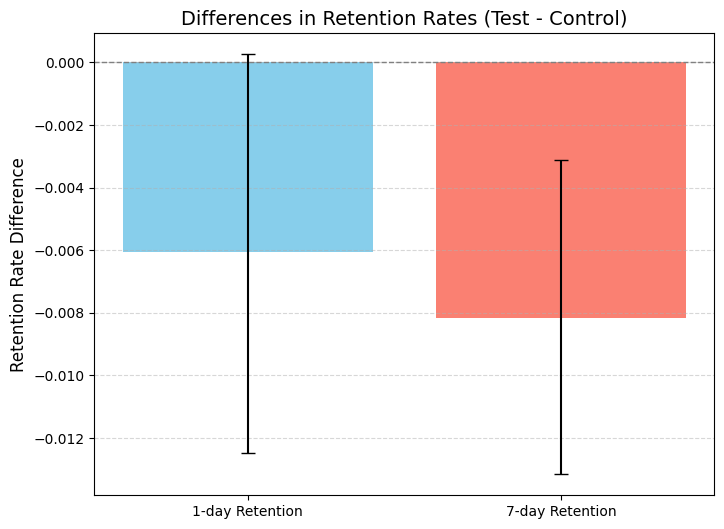

In [81]:
import matplotlib.pyplot as plt

# Data for plotting
labels = ['1-day Retention', '7-day Retention']
mean_differences = [retention_1_ci[0], retention_7_ci[0]]
lower_errors = [retention_1_ci[0] - retention_1_ci[1], retention_7_ci[0] - retention_7_ci[1]]
upper_errors = [retention_1_ci[2] - retention_1_ci[0], retention_7_ci[2] - retention_7_ci[0]]

# Bar plot with error bars
plt.figure(figsize=(8, 6))
plt.bar(labels, mean_differences, yerr=[lower_errors, upper_errors], color=['skyblue', 'salmon'], capsize=5)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Differences in Retention Rates (Test - Control)', fontsize=14)
plt.ylabel('Retention Rate Difference', fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.show()


I can see that a we go along the days from the installation of the game- the test group preform worse- indicating a drop in retention for the test group.

<h3>Conclusion</h3>

Based on the analysis of **1-day** and **7-day retention rates**, the results suggest that moving the gate from **level 30** (control group) to **level 40** (test group) has a **negative impact on long-term retention**, while the short-term impact is inconclusive:

1. **1-Day Retention**:
   - The test group showed a **small drop** in 1-day retention compared to the control group, with an average difference of **-0.602%**.
   - However, the difference was **not statistically significant**, as the confidence interval includes **0**. This means the observed difference might be due to random variation.

2. **7-Day Retention**:
   - The negative impact on retention becomes clear over time.
   - The test group showed a **statistically significant drop** in 7-day retention, with an average difference of **-0.81%**.
   - The confidence interval for the 7-day retention difference does not include **0**, indicating that this result is unlikely to be due to chance.

Overall, I cannot see an immidiate impact of the gate change, but I do see it getting worse over time.
The A/B test reveals that moving the gate to **level 40** likely **harms long-term retention**. While the 1-day retention impact is uncertain, the negative 7-day retention effect suggests caution before rolling out this change. 

**Recommendations**:
1. **Reassess the Gate Placement**: The gate at **level 40** appears to reduce long-term retention. Consider keeping the gate at **level 30** or testing other placements (e.g., level 35).

2. **Analyze Player Behavior**: Investigate the player experience leading to and beyond the gate:
   - Are players finding levels before or after the gate too difficult or frustrating?
   - Are there external factors (e.g., lack of rewards, pacing) causing disengagement?

-----

<h3>Conducting an A/B test on the retention rates</h3>

Another way to test the statistically significance of the retention rate is with A/B testing.<br>
<code>retention_1</code> and <code>retention_7</code> are binary columns, and therefore my approach is to test their proportions and compare them.<br>

I know that the retention rates in <code>retention_1</code> are 44.78% for the control group and 44.18% for the test group- a proportion test like **Z-test for proportions** will help to determine whether this difference is **large enough to matter.**
<br>
For that- I'll come up with an hypothesis:
- Null Hypothesis ($H_0$)- The retention rates for control and test are the same
- Alternative Hypothesis ($H_1$)- The retention rates for control and test are different
  
$$z=\frac{p_1 - p_2}{\sqrt{p(1-p)(\frac{1}{n_1} + \frac{1}{n_2})}}$$

where:
- $p_1$ and $p_2$ are the proportions of retained users in the control and test groups
- $n_1$ and $n_2$ are the sample sizes in the control and test groups
- $p$ is the combined proportion in both groups

$$p=\frac{x_1+x_2}{n_1+n_2}, p_1=\frac{x_1}{n_1}, p_2=\frac{x_2}{n_2}$$

In [83]:
# Control group- p1=success_control/n_control
success_control = df[df['version'] == 'control']['retention_1'].sum()
n_control = df[df['version'] == 'control']['retention_1'].count()

# Test group- p2=success_test/n_test
success_test = df[df['version'] == 'test']['retention_1'].sum()
n_test = df[df['version'] == 'test']['retention_1'].count()

# Perform Z-Test
z_stat, p_value = proportions_ztest([success_control, success_test], [n_control, n_test])
print(f"Z-Statistic: {z_stat:.4f}, P-Value: {p_value:.4f}")

Z-Statistic: 1.8227, P-Value: 0.0684


The Z-statistic is 1.8227- meaning the difference between the control and test group is $1.8227\sigma$ from 0.<br>
A p-value of 0.0684 means that there is a chance of 6.84% that the difference we see is due to random variation.

The $p-value>5\%$- meaning that I failed rejecting $H_0$.
This is basically what I saw on the **bootstrapping process**- that for 1-day retention I cannot say there is a statistical difference between the control and test groups.

I'll test it now on the 7-day retention:

In [84]:
# Control group- p1=success_control/n_control
success_control = df[df['version'] == 'control']['retention_7'].sum()
n_control = df[df['version'] == 'control']['retention_7'].count()

# Test group- p2=success_test/n_test
success_test = df[df['version'] == 'test']['retention_7'].sum()
n_test = df[df['version'] == 'test']['retention_7'].count()

# Perform Z-Test
z_stat, p_value = proportions_ztest([success_control, success_test], [n_control, n_test])
print(f"Z-Statistic: {z_stat:.4f}, P-Value: {p_value:.4f}")

Z-Statistic: 3.1352, P-Value: 0.0017


The Z-statistic is 3.1352- meaning the difference between the control and test group is $3.1352\sigma$ from 0.<br>
A p-value of 0.0017 means that there is a chance of 0.17% that the difference we see is due to random variation.

The $p-value<5\%$- meaning that I'm rejecting $H_0$ and there is a statistically significant difference between the control and test groups.

Overall, it says that when the gate is at level 40, there is a **statistically significant lower 7-day retention rate** compared to the gate at level 30.

---
<h3>Comparison of Results</h3>

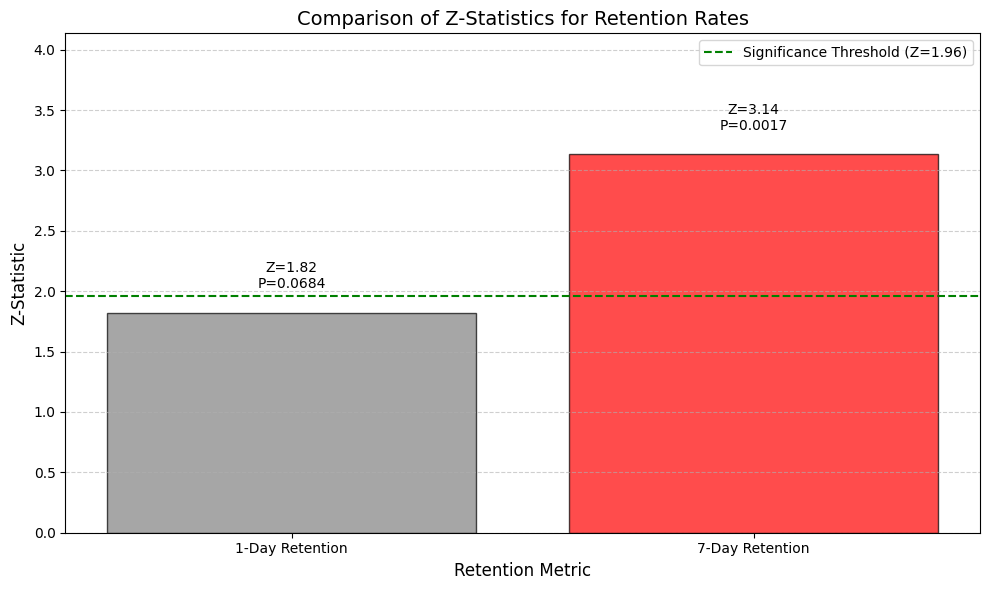

In [86]:
# Data for visualization
metrics = ['1-Day Retention', '7-Day Retention']
z_statistics = [1.8227, 3.1352]  # Z-Statistic values
p_values = [0.0684, 0.0017]  # P-Value values
significance = [p < 0.05 for p in p_values]  # Significance flags

# Bar colors based on significance
colors = ['gray' if not sig else 'red' for sig in significance]

# Visualization
plt.figure(figsize=(10, 6))

# Bar plot for Z-Statistics
plt.bar(metrics, z_statistics, color=colors, alpha=0.7, edgecolor='black')
plt.axhline(1.96, color='green', linestyle='--', label='Significance Threshold (Z=1.96)', linewidth=1.5)

# Add labels and titles
for i, (z, p) in enumerate(zip(z_statistics, p_values)):
    plt.text(i, z + 0.2, f'Z={z:.2f}\nP={p:.4f}', ha='center', fontsize=10)

plt.title('Comparison of Z-Statistics for Retention Rates', fontsize=14)
plt.xlabel('Retention Metric', fontsize=12)
plt.ylabel('Z-Statistic', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.ylim(0, max(z_statistics) + 1)

# Show plot
plt.tight_layout()
plt.show()




| Metric             | Z-Statistic | P-Value | Statistical Significance | Observations                                  |
|---------------------|-------------|---------|---------------------------|-----------------------------------------------|
| **1-Day Retention** | 1.8227      | 0.0684  | Not Significant           | Small negative difference, likely due to random variation. |
| **7-Day Retention** | 3.1352      | 0.0017  | Statistically Significant | Clear negative difference; test group retention is worse. |
<br>

- **Short-Term Impact (1-Day Retention)**:
  - The difference is **small and inconclusive**. The gate change does not significantly affect short-term retention.
  - Players seem equally likely to return on the first day regardless of the gate's placement.

- **Long-Term Impact (7-Day Retention)**:
  - The gate change to level 40 **significantly reduces 7-day retention**.<br> Players in the test group are less likely to stay engaged over time, which could have **negative long-term implications** for player retention and monetization.

<h3>Recommendations</h3>

1. **Keep the Gate at Level 30**: <br>The gate at level 30 performs better for long-term retention, a critical metric for sustaining engagement.

2. **Investigate the Gate at Level 40**: <br>
   Analyze why the gate at level 40 leads to lower 7-day retention:
    - **Difficulty**: Are players struggling to pass levels before or after the gate?
    - **Frustration**: Does the gate disrupt gameplay flow or discourage continued play?

3. **Run Additional Tests**: <br>
   Test alternate gate placements (for example in level 35) or adjust gameplay mechanics near the gate to reduce player churn.

4. **Monitor Other Metrics**: <br>
    Check if the gate change impacts other key metrics like **session duration**, **revenue**, or **level completion rates**.